## Estimation of subjective income risk profile using SCE data

- parameters to estimate:
   - $\tilde \Gamma_l$ and $\tilde \Gamma_h$ 
   - transition matrix $\Omega$ with $p$ and $q$ as the staying probability in low and high risk states, respectively.
  - where $\tilde \Gamma_l = \{\tilde \sigma^l_\psi,\tilde \sigma^l_\theta, \tilde{\mho^l}, \tilde{E^l}\}$ and $\tilde \Gamma_h = \{\tilde \sigma^h_\psi,\tilde \sigma^h_\theta, \tilde{\mho^h}, \tilde{E^h}\}$ where we impose the restriction that $\tilde \sigma^h_\psi > \tilde \sigma^l_\psi$ and $\tilde \sigma^h_\theta > \tilde \sigma^l_\theta$
  
Two extensions
- I also estimate various versions of these profile specific to group, such as age and education. 
- I also estimate this conditional on macroeconomic history 

### Data and Estimation

For each individual $i$, we observe at most 12 observations of their perceived income volatility over the earning growth next year $\tilde {var}_{i,t}$ from $t$ to $t+12$. We assume the following relation between observed survey income volatility and underlying perceived permanent/transitory risks by the individual $i$ at time $t$ 

$\newcommand{\var}{\text{var}}$


$$\tilde {\var}_{i,t}= (12 \tilde \sigma^2_{i,t,\psi} + 1/12 \tilde \sigma^2_{i,t,\theta})exp^{\xi_{t}}exp^{\eta_{i}}exp^{\epsilon_{i,t}} \\
\log \tilde {\var}_{i,t}= (12 \tilde \sigma^2_{i,t,\psi} + 1/12 \tilde \sigma^2_{i,t,\theta})+\xi_{t}+\eta_{i}+\epsilon_{i,t}$$

Individual fixed effect $\eta_i$ and time-fixed effect $\xi_t$ can be directly controlled for. The i.i.d shock $\epsilon_{i,t}$ represents unobserved information  that is available to agent $i$ but not available to modelers. It can be also interpreted as any idiosyncratic shock that affect the risk perceptions of individual $i$. We assume it is log-normally distributed.

$$\epsilon_{i,t} \sim N(0,\sigma^2_\epsilon)$$

Notice that $\tilde {\var}_{i,t}$ alone is not enough to separately identify the component-specific perceived risk parameters. 

Therefore, I make the following auxiliary assumption: the agent adopts a constant ratio of decomposition between permanent and transitory risks, $\kappa =\frac{\tilde \sigma_{i,t,\psi}}{\tilde \sigma_{i,t,\theta}}$, the value of $\kappa$ is externally estimated from the realized income data. 

With the additional assumption, we can rewrite the above equation.

$$\log(\tilde {\var}_{i,t})= (12+\frac{1}{12\kappa^2})\tilde \sigma^2_{i,t,\psi} + \xi_{t}+\eta_{i}+ \epsilon_{i,t}$$

Now, we transform this model to a general form of Markov switching model. 

$$y_{i,t} = \alpha + \beta \mathbb{1}(S_{i,t}=1)+\tau_{i,t}$$

where 

- $y_{i,t} = \log(\tilde{\var}_{i,t})- \xi_t-\eta_i$
- $\alpha = (12+\frac{1}{12\kappa^2})\tilde \sigma^{l2}_{i,t,\psi}$
- $\beta = (12+\frac{1}{12\kappa^2})(\tilde \sigma^{h2}_{i,t,\psi}-\tilde \sigma^{l2}_{i,t,\psi})$
- $S_{i,t}=1$ if $\tilde \Gamma_{i,t}=\tilde \Gamma^h_{i,t}$ (high risk state) and $S_{i,t}=0$ if $\tilde \Gamma_{i,t}=\tilde \Gamma^l_{i,t}$ (low risk state)
- $\tau_{i,t}$ is the i.i.d. shocks whose variance $\sigma$ is to be estimated

We have data of a short time series of many individuals, each of which is a vector of risk perceptions $\{y_{i,t}\}^{12}_{t=1}$. The objective function of the estiamtion is essentially a sum the log-likelihood proabilities of all individuals. 

In [1]:
import numpy as np
from scipy.optimize import minimize 
import matplotlib.pyplot as plt 
import pandas as pd
import statsmodels.api as sm

In [16]:
class Markov2Switching:
    """
    A class that stores primitives for the Markov Regime Switching Model
    %%%% Model %%%%%%%
    % y_t = alpha+ beta * s_t + epsilon_t
    % y is the observed variable;
    % s_t =1 in high state; s_t = 0 in low state;
    % q=p(s_t=0|s_t-1=0)
    % p=p(s_t=1|s_t-1=1)
    % Transition Matrix from [s=0,s=1]' is [q,1-p;1-q,p] 
    % para_est stores all estimates of parameters. 
    %%%%%%%%%%%%%%%%%

    """

    def __init__(self,
                 Y = None,
                 paras = np.array([0.1,0.1,0.1,0.7,0.7]),
                 state_dependence = False,
                 AR = 0):  
        
        self.Y = Y
        ## be careful with the order 
        self.α = paras[0]
        self.β = paras[1]
        self.σ = paras[2]
        self.q = paras[3]
        self.p = paras[4]
        
        self.state_dependence = state_dependence
        self.AR = AR 
    
    ### pdf function of normal distribution 
    def norm_pdf(self,
                 x,    ## value of the rm 
                 μ,    ## mean of the nromal
                 σ):   ## std of the normal 
        """
        pdf of normal distribution mean μ and variance σ^2
        """
        x_new = (x-μ)/σ
        temp1 = 1/(np.sqrt(2*np.pi))
        temp2 = np.exp(-(x_new**2/2))
        return temp1*temp2 
    
    ## The functions below are help functions 
    ## that turn a hard constraint for parameters to a unconstrainted problem
    ## prob_func  from R -> [0,1]
    def prob_func(self,
                   x):
        """
        this bound function maps unconstrained x to y between 0 and 1
        """
        return 1/(1+np.exp(x))
    
    def prob_func_inv(self,
                     y):
        return np.log(1/y-1)
    
    ## exp_func  from R --> [0,+infinity]
    def exp_func(self,
                 x):
        return np.exp(x)
    
    def exp_func_inv(self,
                     y):
        return np.log(y)
    
    def get_model_para(self,
                      para):
        """
        unconstrained parameters recast into model parameters with constraints
        """
        assert len(para)==5+self.AR,"the nb of parameters is incorrect"
        α = para[0]
        β = self.exp_func(para[1])
        σ = self.exp_func(para[2])
        q = self.prob_func(para[3])
        p = self.prob_func(para[4])
        if self.AR==1:
            ϕ1 = self.prob_func(para[5])
        else:
            ϕ1 = 0.0
        model_para = np.array([α,β,σ,q,p,ϕ1])
        return model_para
    
    def steady_state(self,
                      q,
                      p):
        return ((1-p)/(2-p-q),
                (1-q)/(2-p-q))
    
    ## Key funciton that computes log-likelihood for a list of time series of realized data
    def log_likelihood(self,
                       Y_list,   ## a list of multiple series 
                       para):
        
        """
        inputs
        ======
        Y: a list of independent time series for which the log-likilihood is computed jointly
        para: parameters of the process with strictly set order of α,β,σ,q,p
        
        outputs
        =======
        llh_tot: total log-likelihood across all series
        update1_list: list of updating probs s=1|Y_t at time t;
        prdict1_list: list of prediction probs: s=1|Y_t-1 at time t-1;
        f1_list: list of predicted probs: y_t|y_t-1;
        """
    
        α,β,σ,q,p,ϕ1 = self.get_model_para(para)

        update1_list =[]
        prdict1_list =[]
        f1_list =[]
        
        
        ## starting from zero loglikelihood 
        
        llh_tot = 0.0
        
        for x in range(len(Y_list)):
            Y = Y_list[x]
            T = len(Y_list[x]) ## length of the series is not necessarily the same 
            
            ## this loops over all periods 
            llh = 0.0

            update0 = np.empty(T)
            update1 = np.empty(T)
            prdict1 = np.empty(T)
            f1 = np.empty(T)

            ## initilize the first period 
            update0[0], update1[0] = self.steady_state(q,   #p(s=0|Y_0) and  # p(s=1|Y_1)
                                                       p)   
            
            for t in range(1,T-1):
                prdict1[t] = (1-q)*update0[t-1]+p*update1[t-1]  #p(s_t=1|y_t-1);
                pdf_t_1 =self.norm_pdf(Y[t]-ϕ1*Y[t-1],α+β,σ)* prdict1[t]  # f(y_t|s_t=1,Y_t-1)
                pdf_t_0 =self.norm_pdf(Y[t]-ϕ1*Y[t-1],α,σ)*(1-prdict1[t]) # f(y_t|s_t=0,Y_t-1)
                
                f1[t]= pdf_t_1+pdf_t_0     # f1= f(y_t|Y_t-1)
                #print(f1[t])
                llh_pred = np.log(f1[t])     # log( f(y_t|Y_t-1))
                llh = llh + llh_pred    # llh_pred = log(f(y_t|Y_t-1))
                update1[t] = pdf_t_1/(pdf_t_1+ pdf_t_0)  # p(s_t=0|y_t-1) 
                update0[t] = 1-update1[t]                # p(s_t=1|y_t-1)
                
            ## merge those probabilities 
            
            update1_list.append(update1) 
            prdict1_list.append(prdict1)
            f1_list.append(f1)
        
            ## sum across agents 
            llh_tot = llh_tot+llh
        
        return llh_tot,update1_list,prdict1_list,f1_list

In [17]:
## create the model 
mkv2 = Markov2Switching(AR=0)

### Test using fake simulated data with known parameters

In [55]:
import quantecon as qe
from quantecon import MarkovChain

## fake data 
α_fake = 0.1
β_fake = 0.2
σ_fake = 0.1
q_fake = 0.7
p_fake = 0.8
ϕ1_fake = 0.0

mkv_mat = np.array([[q_fake,1-q_fake],
                    [1-p_fake,p_fake]])

para_fake = np.array([α_fake,
                      mkv2.exp_func_inv(β_fake),
                      mkv2.exp_func_inv(σ_fake),
                      mkv2.prob_func_inv(q_fake),
                      mkv2.prob_func_inv(p_fake),
                      #mkv2.prob_func_inv(ϕ1_fake)
                     ])
T_fake = 12
nb_sim = 1000

fake_data_list = []

prob_ss0, prob_ss1 = mkv2.steady_state(q_fake,
                                       p_fake)

init_sim = (np.random.uniform(0,1,nb_sim)<=prob_ss1)*1

for i in range(nb_sim):
    mc = qe.MarkovChain(mkv_mat)
    regime_h = mc.simulate(ts_length=T_fake+1,
                          init= init_sim[i])
    regime_l = 1-regime_h
    shocks = np.random.randn(T_fake+1)*σ_fake
    constant_l = α_fake
    constant_h = α_fake+β_fake
    y = (regime_l*constant_l+regime_h*constant_h)+shocks
    ## AR1 process
    for t in range(1,T_fake):
        y[t]= ϕ1_fake*y[t-1]+y[t]
    
    ## add to the list 
    fake_data_list.append(y[1:])
    
index = range(T_fake)

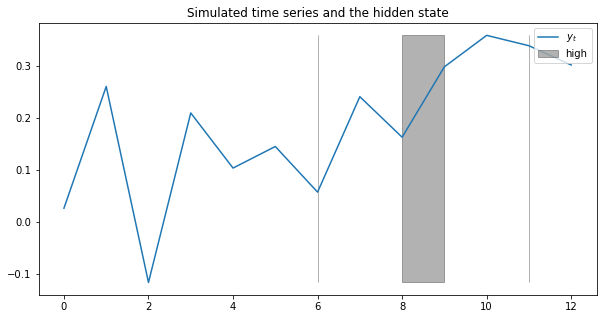

In [56]:
## plot the simulated data 

plt.figure(figsize=(10,5))
plt.title('Simulated time series and the hidden state')
plt.plot(y,label=r'$y_t$')
plt.fill_between(index,
                 np.min(y),
                 np.max(y),
                 where=regime_h[1:],
                 color="k", 
                 alpha=0.3,
                label='high')
plt.legend(loc=1)

In [57]:
## plot log-likelihood 

llh,filter1,pr1,pdf = mkv2.log_likelihood(fake_data_list,
                                          para_fake)

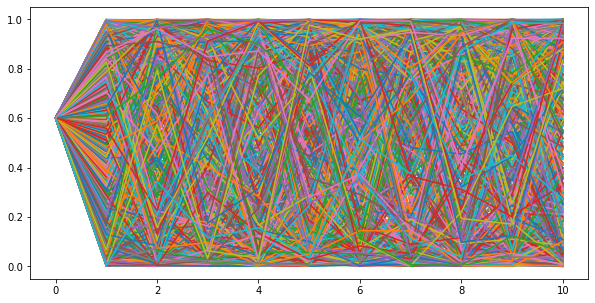

In [58]:
## plot filter probabilities 

plt.figure(figsize=(10,5))
for this in range(nb_sim):
    plt.plot(filter1[this][:-1])

In [60]:
## try estimation

obj = lambda para: -mkv2.log_likelihood(fake_data_list,
                                        para)[0]   ## only the first output

## estimation 
#guess = (0.2,-0.9,0.1,0.1,0.4)
guess = para_fake
bounds = ((-0.3,1),(-2,2),(-2,2),(-4,1),(-4,1),) 

result = minimize(obj,
                    x0 = guess,
                    method='SLSQP',   #SLSQP
                    bounds = bounds,
                    options={'disp': False,
                            }
                   )
print('succees? ',result['success'])
para_est = result['x']

#results
print("fake TRUE parameters",str([float(round(para,2)) for para in mkv2.get_model_para(para_fake)]))
print("initial guess of the parameters",str([float(round(para,2)) for para in mkv2.get_model_para(guess)]))
print("estimated parameters",str([float(round(para,2)) for para in mkv2.get_model_para(para_est)]))


succees?  True
fake TRUE parameters [0.1, 0.2, 0.1, 0.7, 0.8, 0.0]
initial guess of the parameters [0.1, 0.2, 0.1, 0.7, 0.8, 0.0]
estimated parameters [0.09, 0.14, 7.39, 0.27, 0.98, 0.0]


In [45]:
#Based on estimates of parameters and data; compute filtered probabilities

llh,filter1,pr1,pdf = mkv2.log_likelihood(fake_data_list,
                                          para_est)
# filter1: prob of good state;
# pr1: predicted prob of good state 

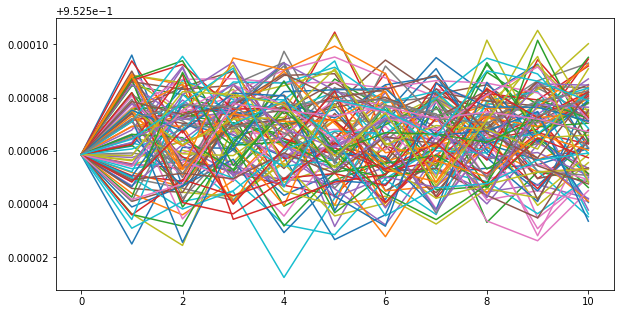

In [46]:
## plot filterred probabilities using estimated parameters 
plt.figure(figsize=(10,5))
for this in range(nb_sim):
    plt.plot(filter1[this][:-1])

### test using macro time series: U.S.  real GDP growth rate 



In [68]:
import pandas_datareader.data as web
import datetime

start = datetime.datetime(1945, 1, 1)
end = datetime.datetime(2019, 12, 31)


rec = web.DataReader("USREC", 
                     "fred", 
                     start, 
                     end)
gdp = web.DataReader('GDPC1',
                     'fred',
                     start,
                     end)
gdp_gr = gdp.pct_change().dropna()
gdp_gr.index = pd.DatetimeIndex(gdp_gr.index, freq="QS")


In [69]:
## use statsmodels 

mod_hamilton = sm.tsa.MarkovAutoregression(
    gdp_gr, 
    k_regimes=2, 
    order= 4, 
    switching_ar=False
)
res_hamilton = mod_hamilton.fit()

In [70]:
res_hamilton.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                    GDPC1   No. Observations:                  287
Model:             MarkovAutoregression   Log Likelihood                 966.274
Date:                  Mon, 29 Nov 2021   AIC                          -1914.549
Time:                          15:40:18   BIC                          -1881.613
Sample:                      04-01-1947   HQIC                         -1901.349
                           - 10-01-2019                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0142      0.004     -3.954      0.000      -0.021      -0.007
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.001     11.821      0.000       0.007       0.010
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.767e-05   5.64e-06     10.223      0.000    4.66e-05    6.87e-05
ar.L1          0.3604      0.063      5.687      0.000       0.236       0.485
ar.L2          0.2617      0.082      3.175      0.001       0.100       0.423
ar.L3         -0.1677      0.077     -2.179      0.029      -0.319      -0.017
ar.L4         -0.1073      0.064     -1.678      0.093      -0.233       0.018
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]     4.005e-20        nan        nan        nan         nan         nan
p[1->0]        0.0276      0.014      1.972      0.049       0.000       0.055
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

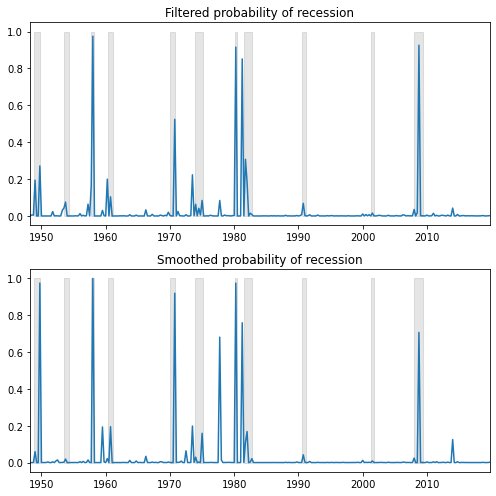

In [71]:
fig, axes = plt.subplots(2, figsize=(7, 7))
ax = axes[0]
ax.plot(res_hamilton.filtered_marginal_probabilities[0])
ax.fill_between(rec.index, 
                0, 
                1, 
                where=rec["USREC"].values, 
                color="k", 
                alpha=0.1)
ax.set_xlim(gdp_gr.index[4], gdp_gr.index[-1])
ax.set(title="Filtered probability of recession")

ax = axes[1]
ax.plot(res_hamilton.smoothed_marginal_probabilities[0])
ax.fill_between(rec.index, 0, 1, where=rec["USREC"].values, color="k", alpha=0.1)
ax.set_xlim(gdp_gr.index[4], gdp_gr.index[-1])
ax.set(title="Smoothed probability of recession")

fig.tight_layout()

In [72]:
## data list 

fake_data_list = [np.array(gdp_gr['GDPC1'])]

obj = lambda para: -mkv2.log_likelihood(fake_data_list,
                                        para)[0]   ## only the first output

## estimation 
guess = (0.0,0.2,0.4,0.2,0.2)
#bounds = [(None,None),(None,None),(0.03,1.0),(0.0,1.0),(0.0,1.0)] 

para_est = minimize(obj,
                    x0=guess,
                    method='L-BFGS-B',
                    options={'disp': True,
                            'maxls':40,
                            'ftol': 2.220446049250313e-11})['x']

#results
print(mkv2.get_model_para(para_est))

llh,filter1,pr1,pdf = mkv2.log_likelihood(fake_data_list,
                                          para_est)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.42872D+02    |proj g|=  4.78750D+02

At iterate    1    f=  1.37493D+02    |proj g|=  3.10798D+02
[-0.28031169  0.8595228   0.61808336  0.48584407  0.44230131  0.        ]

 This problem is unconstrained.
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_22916/2454220542.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  temp1 = 1/(σ*np.sqrt(2*np.pi))
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_22916/2454220542.py:142: RuntimeWarning: invalid value encountered in double_scalars
  update1[t] = pdf_t_1/(pdf_t_1+ pdf_t_0)  # p(s_t=0|y_t-1)
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_22916/2454220542.py:54: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(x))
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_22916/2454220542.py:136: RuntimeWarning: invalid value encountered in double_scalars
  pdf_t_0 =self.norm_pdf(Y[t]-ϕ1*Y[t-1],α,σ)*(1-prdict1[t]) # f(y_t|s_t=0,Y_t-1)
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_22916/2454220542.py:135: RuntimeWarning: invalid value encountered in double_scalars
  pdf_t_1 =self.norm_pdf(Y[t]-ϕ1*Y[t-1],α+β,σ)* prdict1[t]  # f(y_


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F




 Line search cannot locate an adequate point after 20 function
  and gradient evaluations.  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


    5      2     82      2     0     0   3.108D+02   1.375D+02
  F =   137.49289266128093     

ABNORMAL_TERMINATION_IN_LNSRCH                              


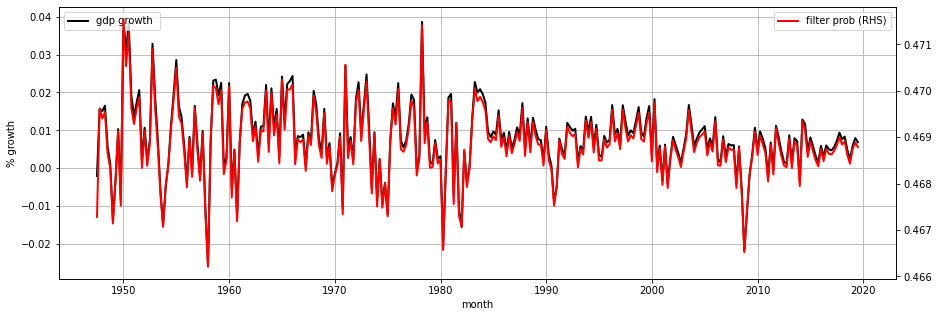

In [75]:
## plot the time series 

lw = 2
figsize = (15,5)
fontsize = 10

## plot 
fig, ax = plt.subplots(figsize = figsize)
ax2 = ax.twinx()
ax.plot(gdp_gr.index[1:-1],
        gdp_gr[1:-1],
        color='black',
           lw= lw,
           label= 'gdp growth ')
ax2.plot(gdp_gr.index[1:-1],
         filter1[0][1:-1],
         'r-',
         lw = lw,
         label = 'filter prob (RHS)')
ax.legend(loc = 2,
         fontsize = fontsize)
ax.set_xlabel("month",fontsize = fontsize)
ax.grid()
ax.set_ylabel('% growth',fontsize = fontsize)
ax.tick_params(axis='both', 
               which='major', 
               labelsize = fontsize)
ax2.tick_params(axis='both', 
               which='major', 
               labelsize = fontsize)
ax2.fill_between(rec.index, 
                min(filter1[0][1:-1]), 
                max(filter1[0][1:-1]), 
                where=rec["USREC"].values, 
                color="k", 
                alpha=0.1)
ax2.legend(loc = 1,
          fontsize = fontsize)